In [29]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../mermaid'))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label==9
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

ds = torch.utils.data.TensorDataset(torch.Tensor(images))
d1, d2 = (torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, ) for _ in (1,1))

BATCH_SIZE = 512

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)


class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        parameters = pars.ParameterDict()
        parameters.load_JSON("mermaid_config_svf.json")
        self.sz = np.array([BATCH_SIZE, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        mf = py_mf.ModelFactory(self.sz, self.spacing, self.sz, self.spacing)
        net, loss = mf.create_registration_model(
            'lddmm_shooting_map', parameters["model"])
        loss.add_similarity_measure("ssd", smf.SSDSimilarity)

        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
        self.mermaid_unit = net.cuda()
        self.mermaid_loss = loss
        
        self.regis_net = RegisNet().cuda()
        

    def forward(self, moving_image, fixed_image):
        
        #modify self.mermaid_unit.m here
        m = self.regis_net(moving_image, fixed_image)
        self.mermaid_unit.m = m
        self.mermaid_loss.m = m
        
        #this call modifies self.phi
        self.warped_moving_image = self.__mermaid_shoot__(moving_image)
        
        all_loss, sim_loss, reg_loss = self.mermaid_loss(
            self.identityMap, 
            self.phi,
            moving_image,
            fixed_image,
            None,
            variables_from_forward_model=self.mermaid_unit.get_variables_to_transfer_to_loss_function(),
            variables_from_optimizer=None
        )
        self.loss_dict = {
            'all_loss': all_loss / self.sz[0],
            'sim_loss': sim_loss / self.sz[0],
            'reg_loss': reg_loss / self.sz[0]
        }

    def __mermaid_shoot__(self, moving_image):
        self.phi=self.mermaid_unit(self.identityMap, moving_image)
        warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, 
            self.phi,
            self.spacing,
            spline_order=1
        )
        return warped_moving_image



net = MermaidNet()
0

In [69]:
optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

In [70]:
net.train()

MermaidNet(
  (mermaid_unit): LDDMMShootingVectorMomentumMapNet(
    (integrator): ODEWrapBlock()
  )
  (mermaid_loss): LDDMMShootingVectorMomentumMapLoss()
  (regis_net): RegisNet(
    (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(22, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(42, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv6): Conv2d(52, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [74]:
for _ in range(240):
    for moving, fixed in list(zip(d1, d2)):
        if moving[0].size()[0] == BATCH_SIZE:
            moving_image = moving[0].cuda()
            fixed_image = fixed[0].cuda()
            optimizer.zero_grad()
            net(moving_image, fixed_image)
            loss = net.loss_dict["all_loss"]
            print(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()


Using default value = rk4 for key = solver of category = root.model.registration_model.forward_model
Using default value = True for key = adjoin_on of category = root.model.registration_model.forward_model
Using default value = 1e-05 for key = rtol of category = root.model.registration_model.forward_model
Using default value = 1e-05 for key = atol of category = root.model.registration_model.forward_model
Using default value = 20 for key = number_of_time_steps of category = root.model.registration_model.forward_model


/media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Creating new category: root.model.registration_model.similarity_measure
Using default value = ssd for key = type of category = root.model.registration_model.similarity_measure
Using ssd similarity measure
Using default value = 0.1 for key = sigma of category = root.model.registration_model.similarity_measure
[12.946022]
[12.068602]
[11.5133]
[10.786672]
[9.982917]
[9.610741]
[9.918587]
[9.707481]


KeyboardInterrupt: 

In [72]:
phi = np.array((net.phi).cpu().detach())
iden = np.array(net.identityMap.cpu())

AttributeError: 'MermaidNet' object has no attribute 'phi'

In [51]:
iden.shape

(128, 2, 28, 28)

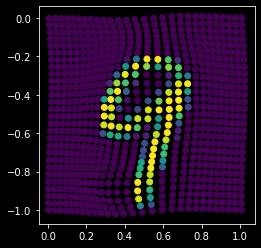

In [56]:
N = 71
plt.style.use("dark_background")
l = 0
a = l * iden + (1 - l) * phi
plt.axes().set_aspect('equal')
plt.scatter(a[N][1].flatten(), -a[N][0].flatten(), 
            c=fixed_image[N, 0].cpu().numpy().flatten())

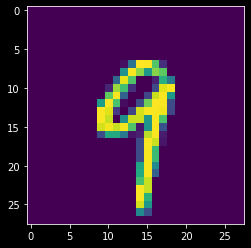

In [57]:
plt.imshow(fixed_image[N, 0].cpu().numpy())

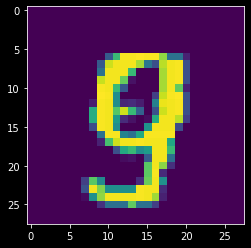

In [58]:
plt.imshow(moving_image[N, 0].cpu().numpy())

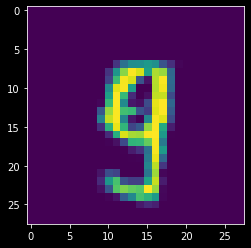

In [59]:
plt.imshow(net.warped_moving_image[N, 0].detach().cpu())

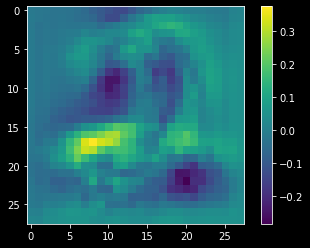

In [17]:
plt.imshow(net.mermaid_unit.m[N, 0].cpu().detach())
plt.colorbar()

In [18]:
def get_phi(a, b):
    net(a, b)
    return net.phi.detach().cpu()

In [19]:
phi1 = get_phi(moving_image, fixed_image)
phi2 = get_phi(fixed_image, moving_image)

/media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


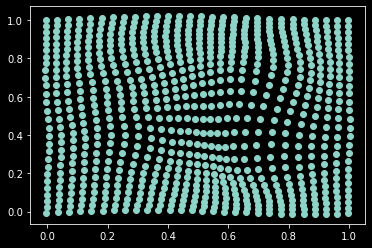

In [20]:
plt.scatter(phi1[N, 0], phi1[N, 1])

In [21]:
ident_hope = py_utils.compute_warped_image_multiNC(phi1, phi2, net.spacing, 1)

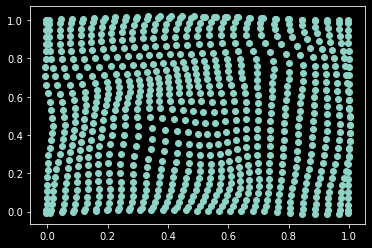

In [22]:
plt.scatter(ident_hope[N, 0], ident_hope[N, 1])

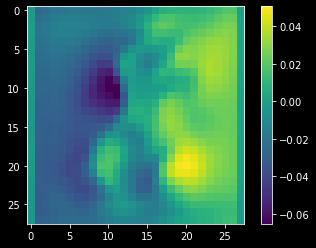

In [96]:
plt.imshow(ident_hope[N, 1] - iden[N, 1])
plt.colorbar()

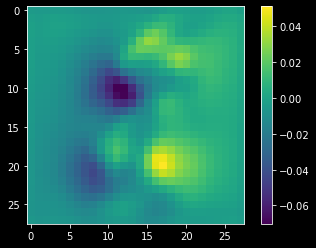

In [98]:
plt.imshow(phi2[N, 1] - iden[N, 1])
plt.colorbar()

In [5]:
import json

In [10]:
json.load(open("mermaid_config_svf.json", "r"))

{'model': {'deformation': {'compute_similarity_measure_at_low_res': False,
   'use_map': True},
  'registration_model': {'load_velocity_from_forward_model': True,
   'spline_order': 1,
   'type': 'svf_map',
   'env': {'get_momentum_from_external_network': True,
    'use_odeint': True,
    'reg_factor': 10.0}}}}

In [18]:
net.mermaid_unit.m

tensor([[[[ 1.8210e-07, -7.0045e-08,  8.6584e-08,  ...,  9.6265e-08,
           -1.0714e-07, -6.2749e-08],
          [ 6.3618e-08, -2.9080e-08,  1.0044e-07,  ...,  1.7630e-07,
            7.2663e-10, -6.0848e-08],
          [-9.9639e-09,  8.0996e-08, -1.3020e-07,  ...,  1.9007e-08,
            9.3819e-08, -7.3139e-08],
          ...,
          [-3.0777e-09,  3.4346e-09, -2.6429e-08,  ...,  5.2040e-08,
           -1.9014e-07, -5.8176e-08],
          [-6.6768e-08,  5.6820e-08,  1.0817e-08,  ...,  1.0500e-08,
           -2.0653e-07,  1.8495e-07],
          [ 1.8517e-07, -1.3943e-07,  1.3040e-07,  ..., -1.0652e-08,
            1.0604e-08,  3.0844e-08]],

         [[ 4.7274e-08,  9.7902e-08,  6.7238e-08,  ...,  2.0446e-08,
            4.9523e-08, -1.3523e-08],
          [-2.1141e-08,  4.6602e-09, -4.0182e-08,  ..., -5.2954e-08,
            5.7505e-09, -2.3531e-08],
          [-9.8935e-09, -4.4768e-09, -5.6421e-08,  ...,  4.8755e-08,
           -1.0694e-07, -1.7360e-07],
          ...,
     

In [28]:
n2  = net.regis_net

In [33]:
net.regis_net = n2